In [1]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from sklearn.metrics import balanced_accuracy_score, adjusted_mutual_info_score
from utils_hiv.DRM_utils import * 
from matplotlib.lines import Line2D

In [2]:
os.chdir('/Users/lucblassel')

In [3]:
countries = ['Africa', 'UK']
models = ['NB', 'LR', 'RF', 'B1']
subtypes = ['ALL', 'B', 'C']
test_sets = ['Africa', 'UK C', 'UK B']
targets = ['encoded_label', 'hasDRM']
tasks = ['all features\nkept', 'DRM features\nremoved']

In [4]:
dirname = 'whole_dataset_multi_targets/by_drm_counts'
for target in targets:
    os.makedirs(os.path.join(dirname, target), exist_ok=True)

# Reading and preparing data
## Reading data

In [5]:
all_preds = pd.read_csv('whole_dataset_multi_targets/all_preds.tsv', sep='\t', index_col=0)
all_preds.index = all_preds.index.astype(str)

In [6]:
data = pd.concat([
    pd.read_csv(f'Documents/Work/hiv-drm-detection/data_pre_split/{country}-data-with-scores.tsv.homo',
            sep='\t', index_col=0) for country in countries
], axis=0)
data.index = data.index.astype(str)
data['dataset'] = 'Africa'
data.loc[data.filter(regex=r'^\d+$', axis=0).index, 'dataset'] = 'UK'

## Subsetting dataset

In [7]:
subtype_slicer = (
    (
        (all_preds['dataset'] == 'Africa') & 
        (all_preds['subtype'] == 'ALL')
    ) | (
        (all_preds['dataset'] == 'UK') & 
        (all_preds['subtype'] != 'ALL')
    )
)

subset = all_preds[
    (subtype_slicer) & 
    (all_preds['shorthand'].isin(models))
]

subset['test set'] = subset['subtype'].apply({'ALL':'Africa', 'B':'UK C', 'C':'UK B'}.get)

## categorizing sequences by number of DRMs

In [8]:
drm_getters = {
    'All DRMs': (get_all_DRMs, 10),
    'SDRMs': (get_SDRMs, 8),
    'DRMs only': (get_DRMs_only, 4),
    'NRTI': (get_NRTI, 7),
    'NNRTI': (get_NNRTI, 4),
    'Other': (get_Other, 3),
    'Primary DRMs': (get_standalone, 6),
    'Accessory DRMs': (get_accessory, 6)
}

In [9]:
counts = pd.concat([
    data.filter(func(), axis=1).sum(axis=1).apply(lambda x: f"={x}" if x < cutoff else f">={cutoff}").rename(f"{key} count")
    for key, (func, cutoff) in drm_getters.items()
], axis=1)

In [10]:
subset = subset.join(counts)

In [31]:
melted_by_count = pd.melt(subset, id_vars=subset.columns.tolist()[:-len(drm_getters)], var_name='count type', value_name='count')

# computing scores

In [32]:
def get_scores(df):
    return pd.Series({
        'nb. of sequences': len(df),
        'AMI': adjusted_mutual_info_score(df['real'], df['pred']),
        'Balanced accuracy': balanced_accuracy_score(df['real'], df['pred'])
    })

In [33]:
scores = (melted_by_count.groupby(['task', 'test set', 'target', 'shorthand', 'count type', 'count'])
            .apply(get_scores)
            .reset_index())
scores['count type'] = scores['count type'].apply(lambda x: " ".join(x.split()[:-1]))
scores['count'] = scores['count'].apply(lambda x: x[1:] if x[0] == "="else f">{int(x[2:])-1}")
scores['shorthand'] = scores['shorthand'].apply(lambda x: {'B1':'FC'}.get(x,x))

miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains

In [34]:
sub_scores = scores[
    (scores['task'] == tasks[-1]) & 
    (scores['target'] == targets[0])
]

In [42]:
count_order = [
    'All DRMs', 
    'SDRMs', 
    'DRMs only', 
    'Primary DRMs', 
    'Accessory DRMs', 
    'NRTI', 
    'NNRTI', 
    'Other'
]

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


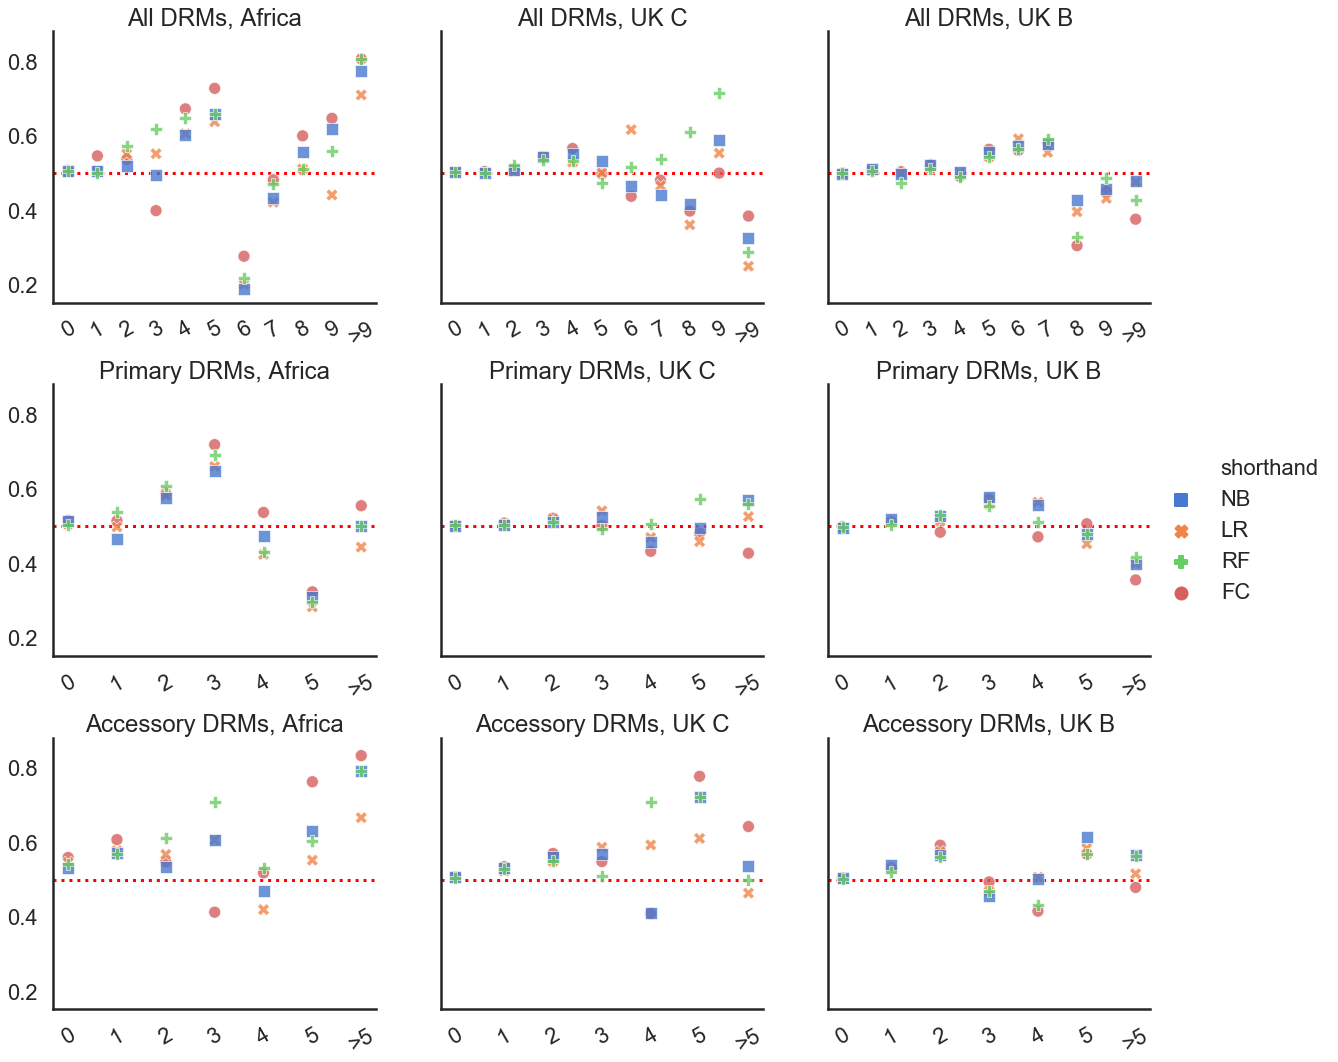

In [48]:
sns.set_context('poster')
grid = (sns.FacetGrid(data=sub_scores, col='test set', col_order=test_sets, row='count type', aspect=1, height=6, 
                      sharex=False, sharey=True, row_order=count_order[:1] + count_order[3:5], 
                      gridspec_kws={'wspace': 0.2, 'hspace':0.3})
            .map_dataframe(sns.scatterplot, x='count', y='Balanced accuracy', hue='shorthand', style='shorthand', 
                           hue_order=['NB', 'LR', 'RF', 'FC'], alpha=0.8, palette='muted')
            .map(plt.axhline, y=0.5, ls=':', color='red', zorder=0.5)
            .set_titles(template="{row_name}, {col_name}")
            .add_legend()
)
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
grid.savefig(os.path.join(dirname, targets[0], 'bal_acc_no_DRMs_subset.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


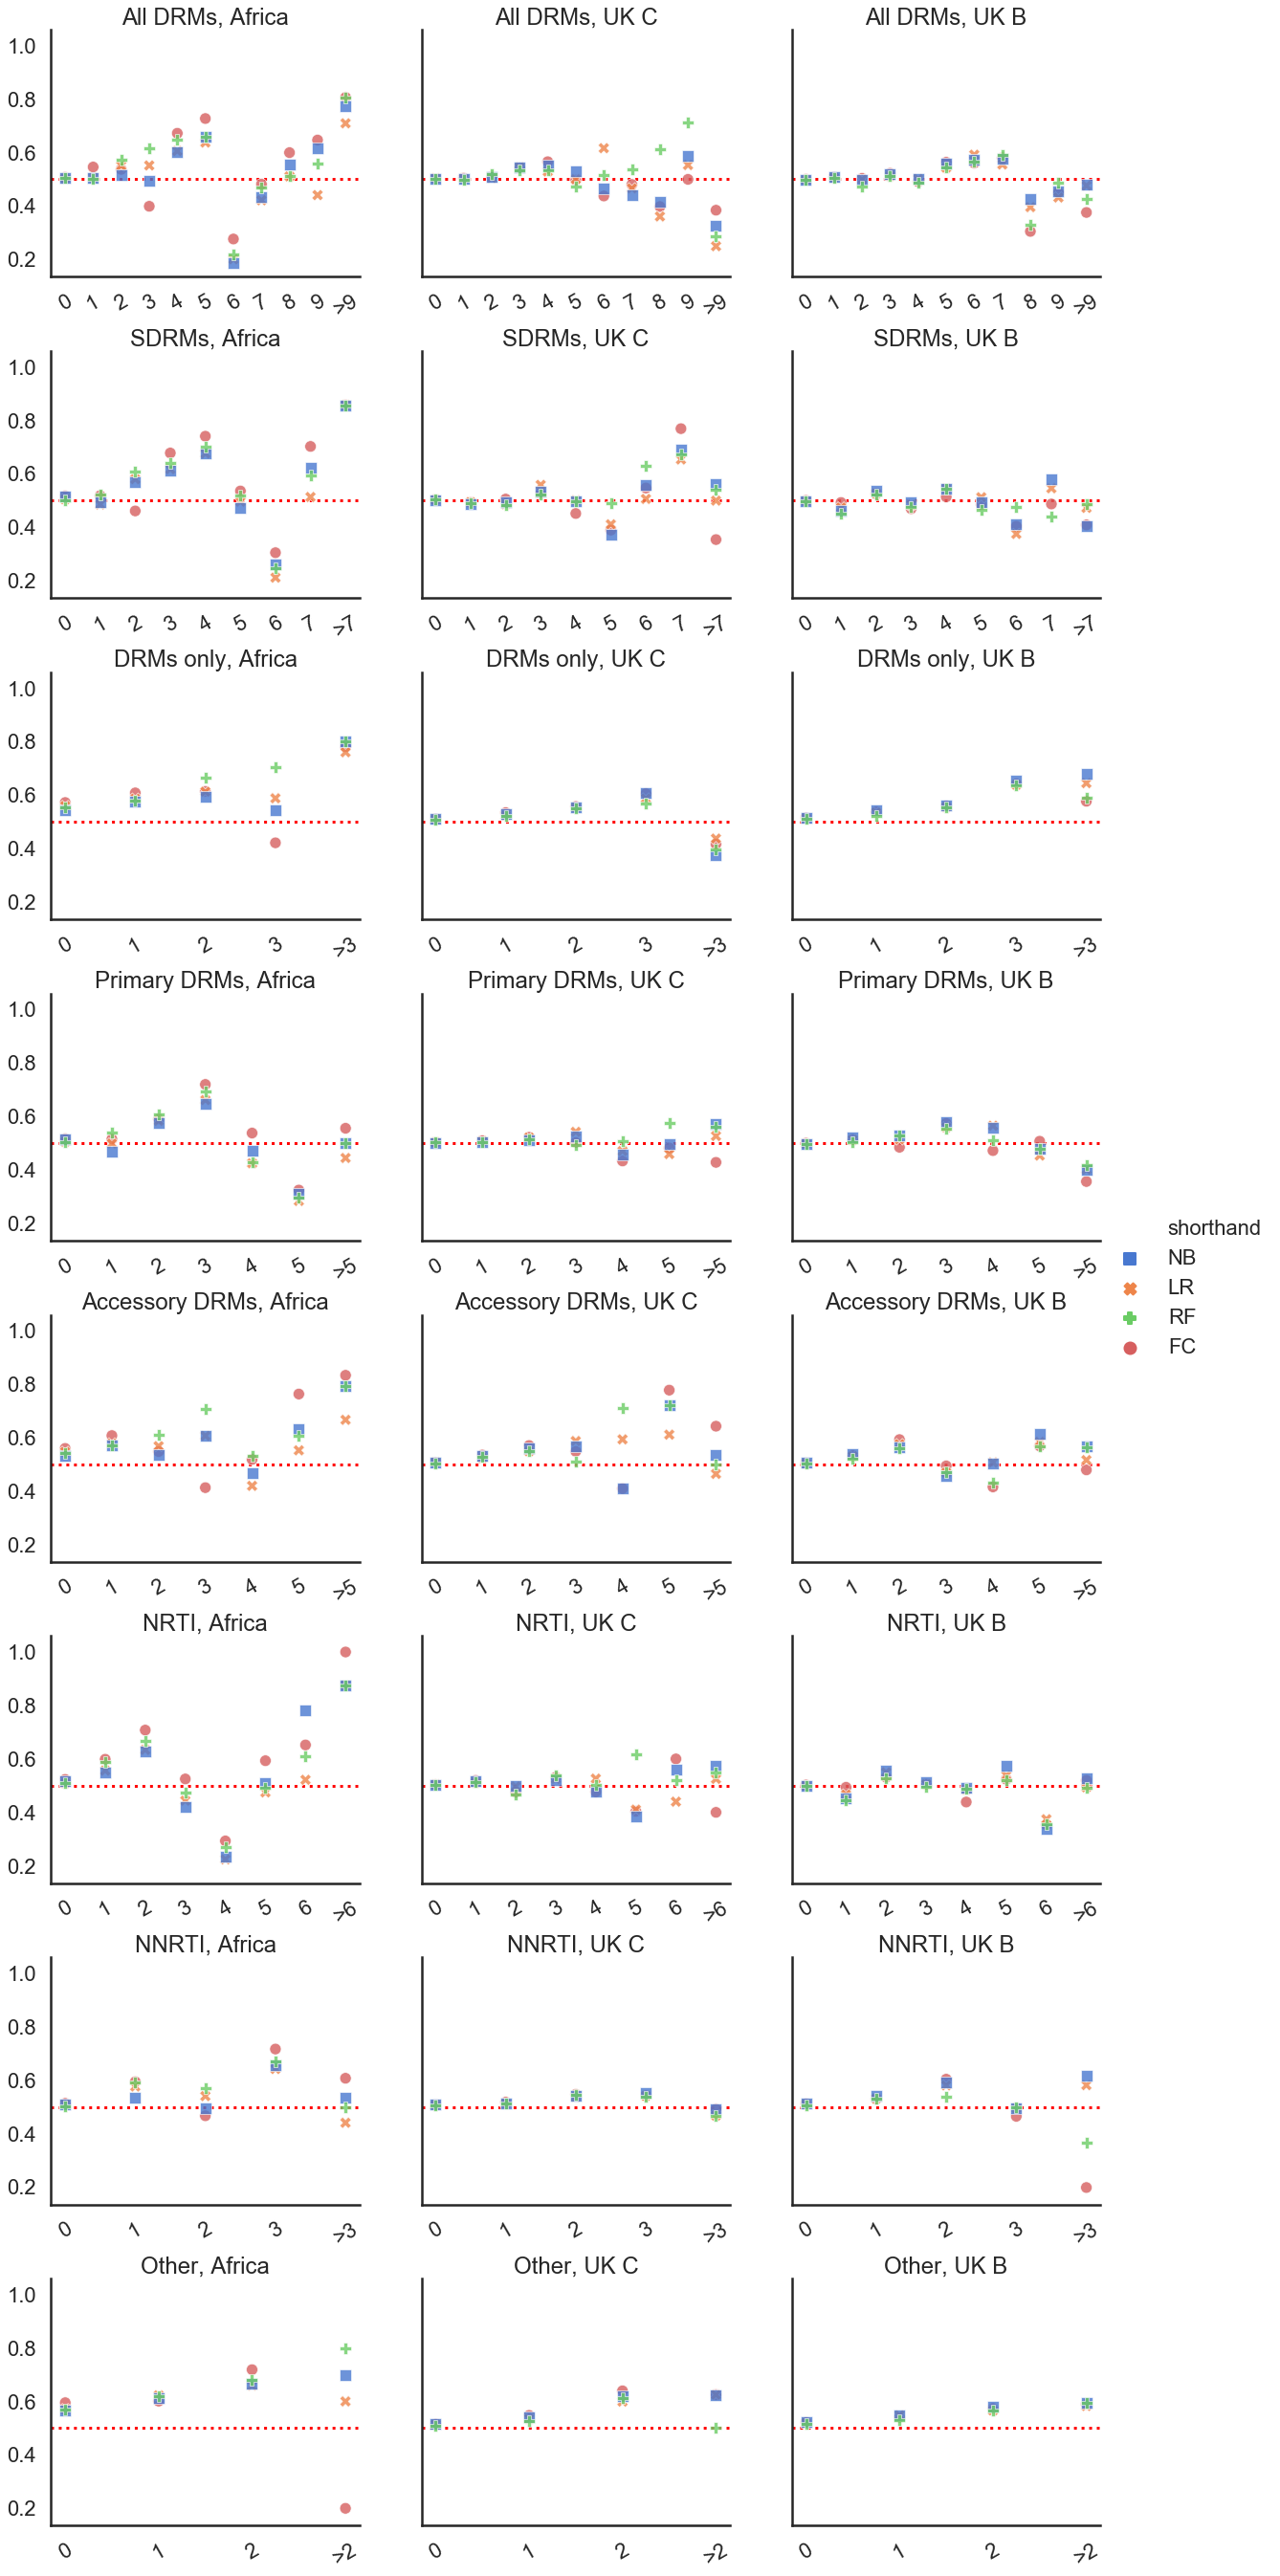

In [49]:
sns.set_context('poster')
grid = (sns.FacetGrid(data=sub_scores, col='test set', col_order=test_sets, row='count type', aspect=1, height=6, 
                      sharex=False, sharey=True, row_order=count_order, 
                      gridspec_kws={'wspace': 0.2, 'hspace':0.3})
            .map_dataframe(sns.scatterplot, x='count', y='Balanced accuracy', hue='shorthand', style='shorthand', 
                           hue_order=['NB', 'LR', 'RF', 'FC'], alpha=0.8, palette='muted')
            .map(plt.axhline, y=0.5, ls=':', color='red', zorder=0.5)
            .set_titles(template="{row_name}, {col_name}")
            .add_legend()
)
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
grid.savefig(os.path.join(dirname, targets[0], 'bal_acc_no_DRMs_all_counts.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


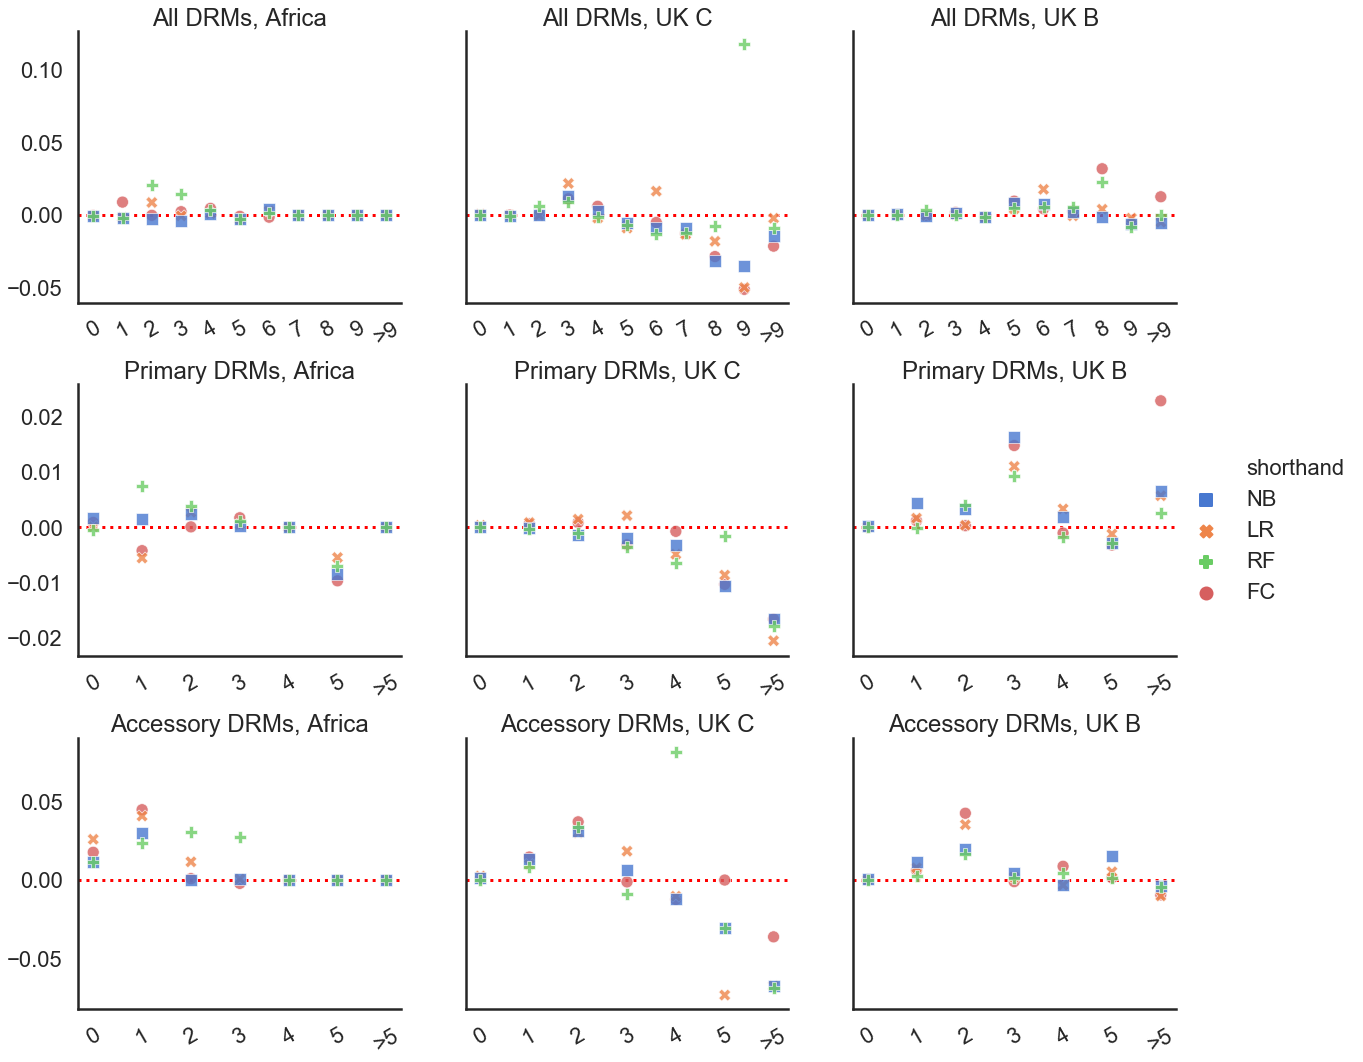

In [50]:
sns.set_context('poster')
grid = (sns.FacetGrid(data=sub_scores, col='test set', col_order=test_sets, row='count type', aspect=1, height=6, 
                      sharex=False, sharey="row", row_order=count_order[:1] + count_order[3:5], 
                      gridspec_kws={'wspace': 0.2, 'hspace':0.3})
            .map_dataframe(sns.scatterplot, x='count', y='AMI', hue='shorthand', style='shorthand', 
                           hue_order=['NB', 'LR', 'RF', 'FC'], alpha=0.8, palette='muted')
            .map(plt.axhline, y=0, ls=':', color='red', zorder=0.5)
            .set_titles(template="{row_name}, {col_name}")
            # .set(yscale='symlog', ylim=(-0.1, 0.1))
            .add_legend()
)
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
grid.savefig(os.path.join(dirname, targets[0], 'AMI_no_DRMs_subset.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


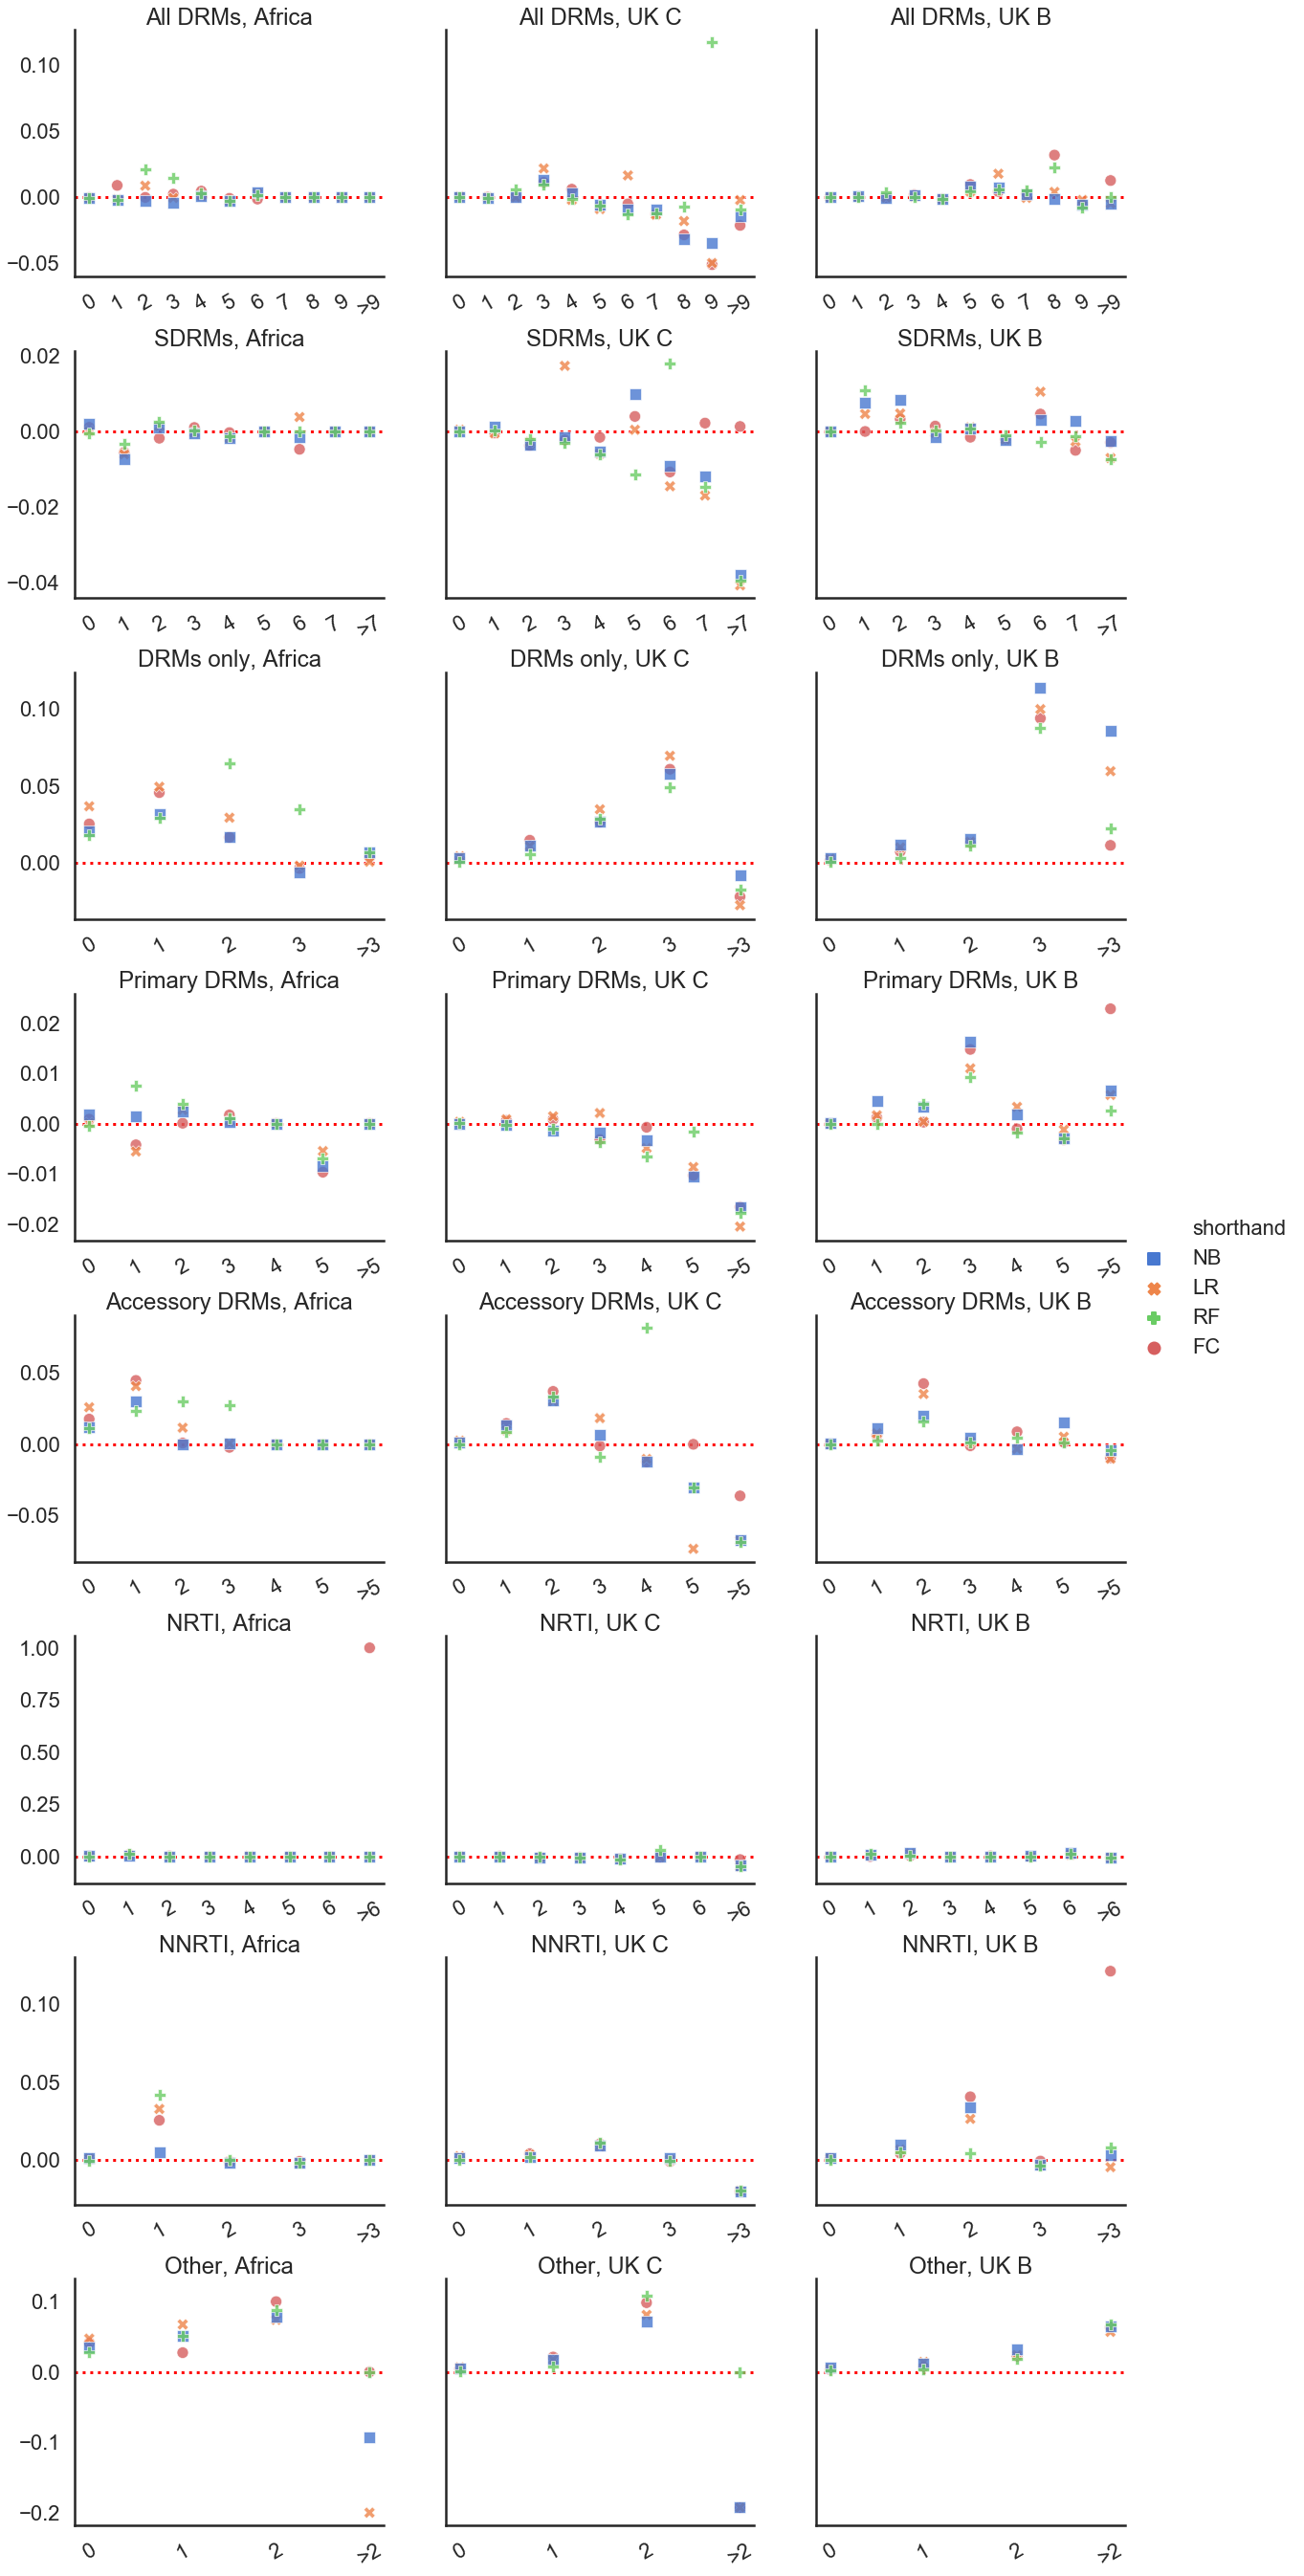

In [51]:
sns.set_context('poster')
grid = (sns.FacetGrid(data=sub_scores, col='test set', col_order=test_sets, row='count type', aspect=1, height=6, 
                      sharex=False, sharey="row", row_order=count_order, 
                      gridspec_kws={'wspace': 0.2, 'hspace':0.3})
            .map_dataframe(sns.scatterplot, x='count', y='AMI', hue='shorthand', style='shorthand', 
                           hue_order=['NB', 'LR', 'RF', 'FC'], alpha=0.8, palette='muted')
            .map(plt.axhline, y=0, ls=':', color='red', zorder=0.5)
            .set_titles(template="{row_name}, {col_name}")
            # .set(yscale='symlog', ylim=(-0.1, 0.1))
            .add_legend()
)
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
grid.savefig(os.path.join(dirname, targets[0], 'AMI_no_DRMs_all_counts.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


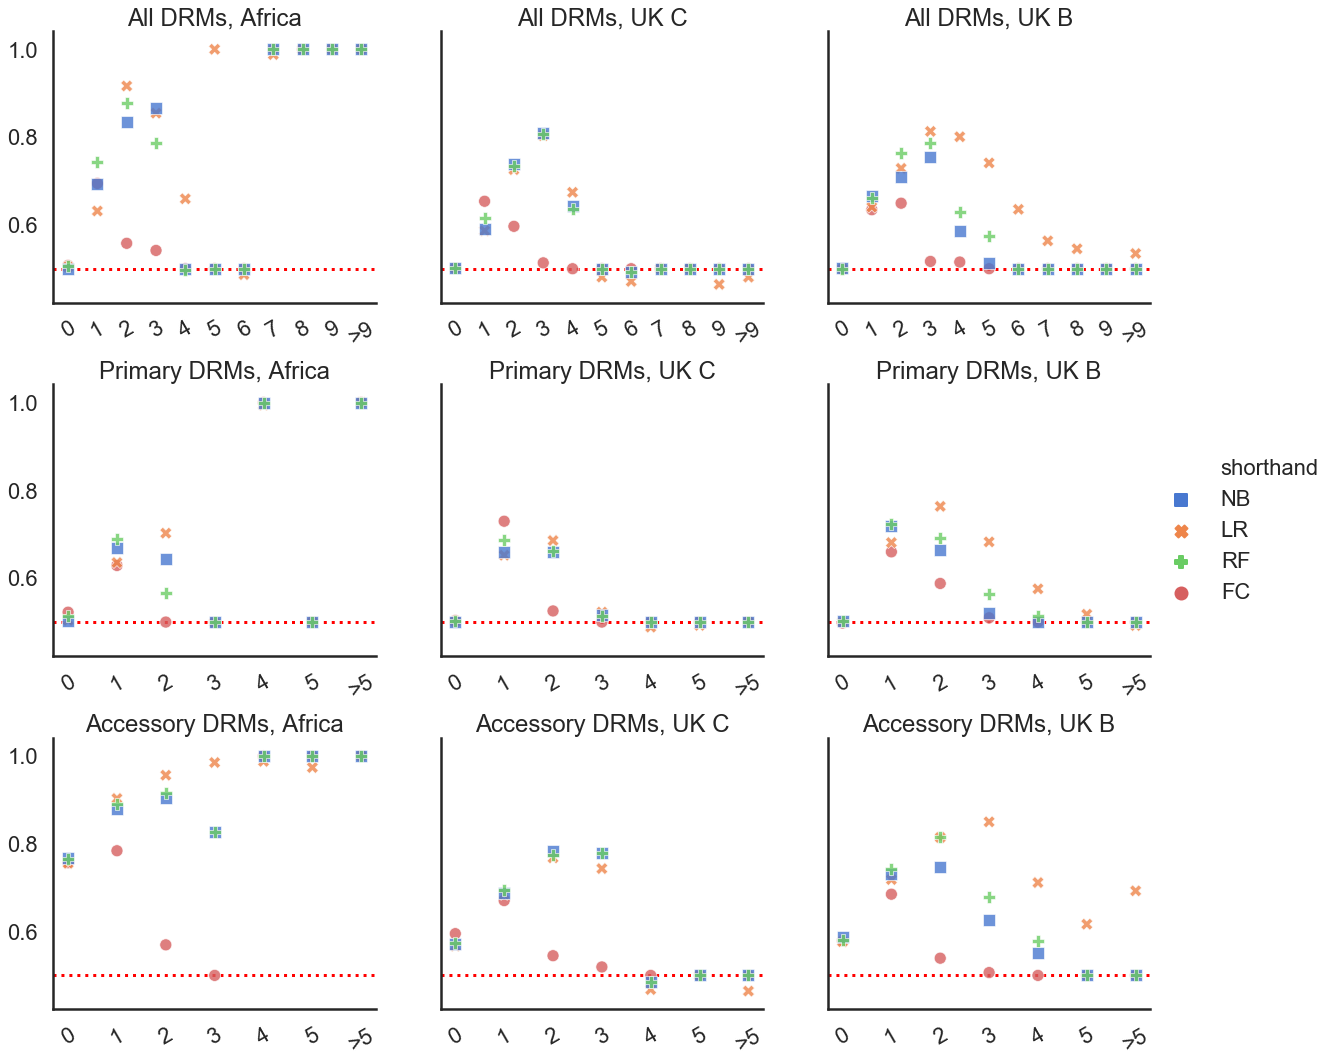

In [52]:
to_plot = scores[
    (scores['task'] == tasks[0]) & 
    (scores['target'] == targets[0])
]
sns.set_context('poster')
sns.set_style('white')
grid = (sns.FacetGrid(data=to_plot, col='test set', col_order=test_sets, row='count type', aspect=1, height=6, 
                      sharex=False, sharey=True, row_order=count_order[:1] + count_order[3:5], 
                      gridspec_kws={'wspace': 0.2, 'hspace':0.3})
            .map_dataframe(sns.scatterplot, x='count', y='Balanced accuracy', hue='shorthand', style='shorthand', 
                           hue_order=['NB', 'LR', 'RF', 'FC'], alpha=0.8, palette='muted')
            .map(plt.axhline, y=0.5, ls=':', color='red', zorder=0.5)
            .set_titles(template="{row_name}, {col_name}")
            .add_legend()
)
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
grid.savefig(os.path.join(dirname, targets[0], 'bal_acc_all_feats_subset.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


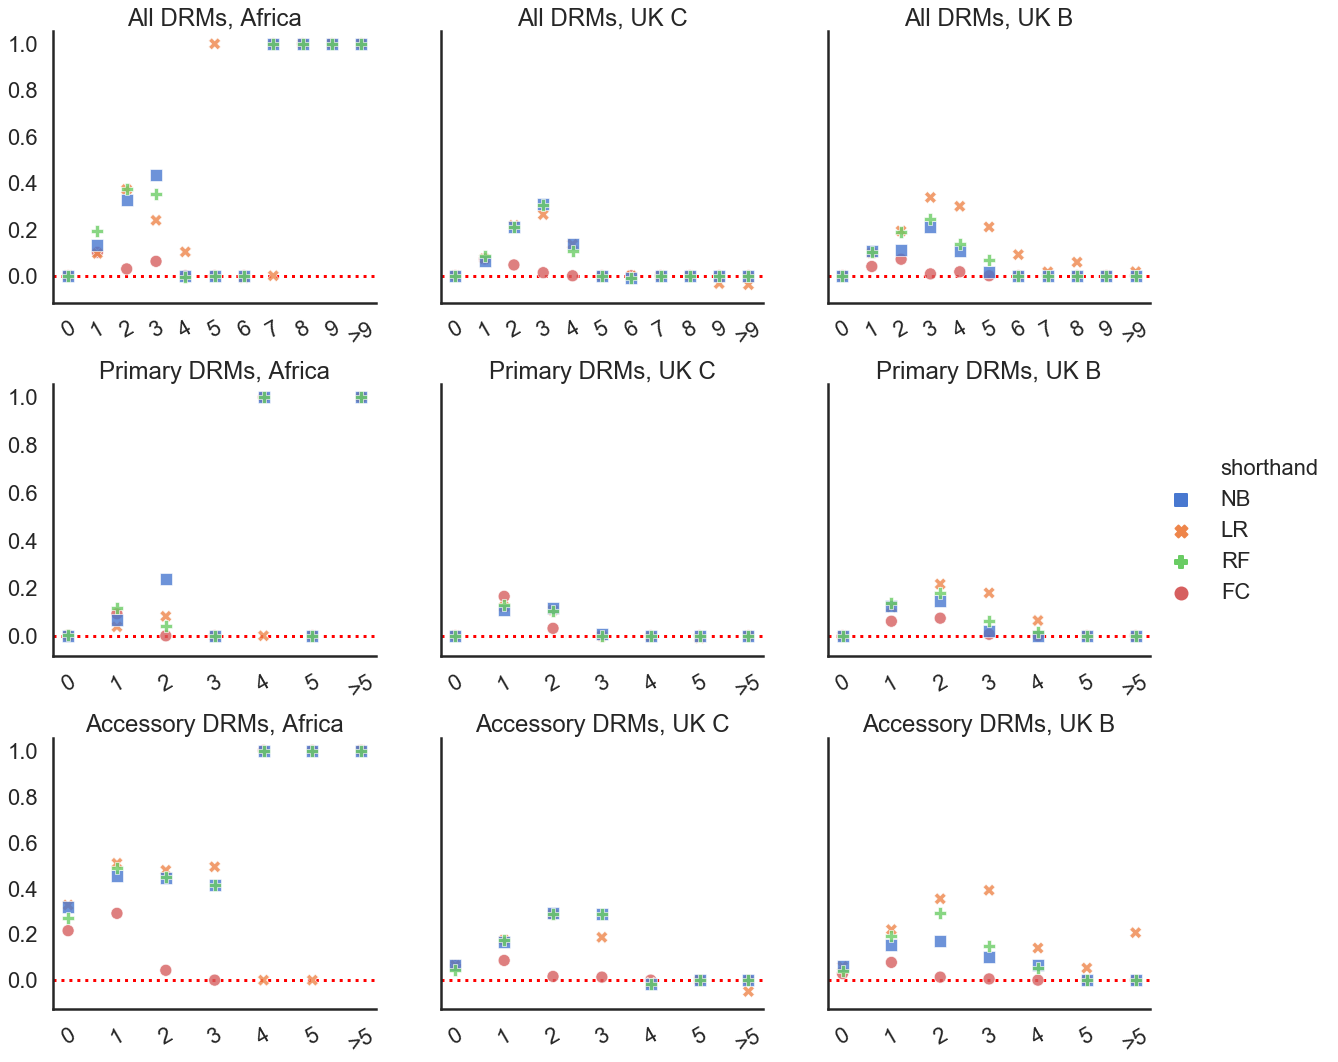

In [53]:
sns.set_context('poster')
sns.set_style('white')
grid = (sns.FacetGrid(data=to_plot, col='test set', col_order=test_sets, row='count type', aspect=1, height=6, 
                      sharex=False, sharey="row", row_order=count_order[:1] + count_order[3:5], 
                      gridspec_kws={'wspace': 0.2, 'hspace':0.3})
            .map_dataframe(sns.scatterplot, x='count', y='AMI', hue='shorthand', style='shorthand', 
                           hue_order=['NB', 'LR', 'RF', 'FC'], alpha=0.8, palette='muted')
            .map(plt.axhline, y=0, ls=':', color='red', zorder=0.5)
            .set_titles(template="{row_name}, {col_name}")
            # .set(yscale='symlog', ylim=(-0.1, 0.1))
            .add_legend()
)
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
grid.savefig(os.path.join(dirname, targets[0], 'AMI_all_feats_subset.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

## grouped plots

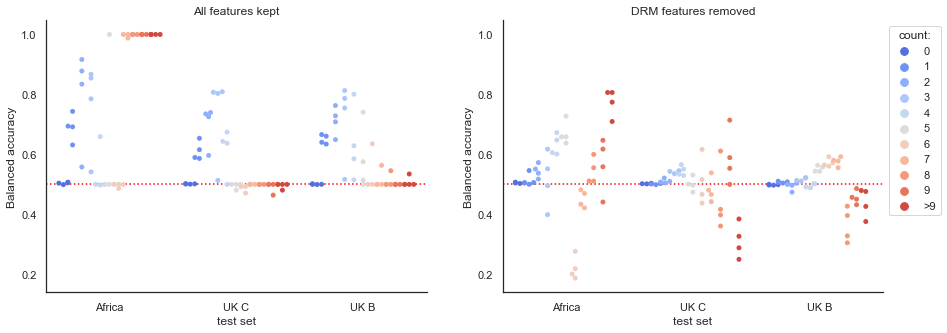

In [54]:
sns.set_context('notebook')
fig = plt.figure(figsize=(15, 5))
gs = mpl.gridspec.GridSpec(1, 2)
ax2 = fig.add_subplot(gs[1])
ax1 = fig.add_subplot(gs[0], sharey=ax2)

to_plot = scores[(scores['count type'] == 'All DRMs') & (scores['target'] == targets[0])]
params = dict(x='test set', order=test_sets, y='Balanced accuracy', hue='count', palette='coolwarm', dodge=True)

sns.swarmplot(data=to_plot[to_plot['task'] == tasks[0]], ax=ax1, **params)
sns.swarmplot(data=to_plot[to_plot['task'] == tasks[1]], ax=ax2, **params)

for ax in [ax1, ax2]:
    ax.axhline(y=0.5, ls=':', color='red', zorder=0.5)

ax1.set_title('All features kept')
ax2.set_title('DRM features removed')

ax1.get_legend().set_visible(False)
ax2.legend(bbox_to_anchor=[1, 1, 0, 0], loc='upper left', title='count:')

sns.despine()

grid.savefig(os.path.join(dirname, targets[0], 'bal_acc_All_counts.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

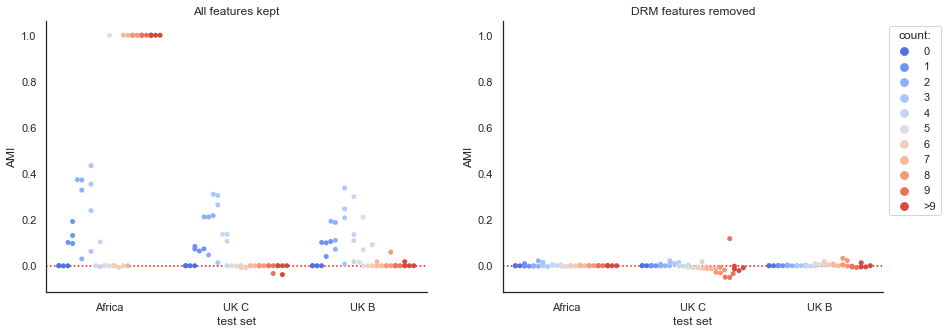

In [55]:
sns.set_context('notebook')
fig = plt.figure(figsize=(15, 5))
gs = mpl.gridspec.GridSpec(1, 2)
ax2 = fig.add_subplot(gs[1])
ax1 = fig.add_subplot(gs[0], sharey=ax2)

to_plot = scores[(scores['count type'] == 'All DRMs') & (scores['target'] == targets[0])]
params = dict(x='test set', order=test_sets, y='AMI', hue='count', palette='coolwarm', dodge=True)

sns.swarmplot(data=to_plot[to_plot['task'] == tasks[0]], ax=ax1, **params)
sns.swarmplot(data=to_plot[to_plot['task'] == tasks[1]], ax=ax2, **params)

for ax in [ax1, ax2]:
    ax.axhline(y=0, ls=':', color='red', zorder=0.5)

ax1.set_title('All features kept')
ax2.set_title('DRM features removed')

ax1.get_legend().set_visible(False)
ax2.legend(bbox_to_anchor=[1, 1, 0, 0], loc='upper left', title='count:')

sns.despine()

grid.savefig(os.path.join(dirname, targets[0], 'AMI_All_counts.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

In [56]:
def plot_line_facet(**kwargs):
    data = kwargs.pop('data')
    _ = kwargs.pop('color', None)
    lineargs = kwargs.pop('lineargs', {})
    pointargs = kwargs.pop('pointargs', {})
    context = kwargs.pop('context', 'notebook')

    # sns.set_context(context)
    ax = sns.lineplot(
        data=data, **kwargs, **lineargs
    )
    # sns.scatterplot(
    #     data=data, ax=ax, **kwargs, **pointargs
    # )
    return ax

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


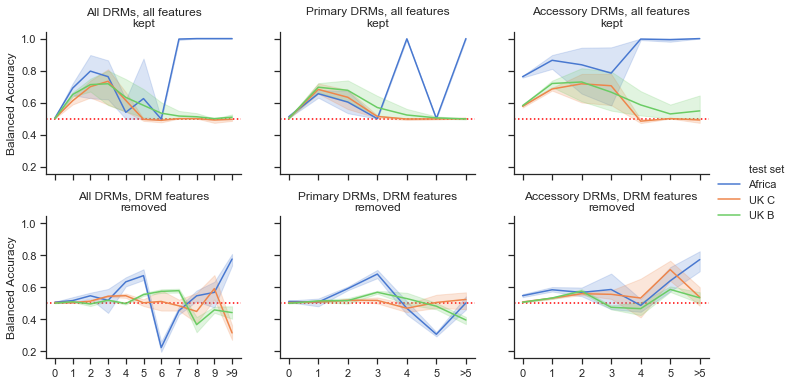

In [62]:
sns.set_context('notebook')
with sns.axes_style('ticks'):
    grid = (sns.FacetGrid(data=scores[scores['target']==targets[0]], col='count type', row='task', sharex='col', sharey=True, 
                          aspect=1.2, col_order=count_order[:1] + count_order[3:5], row_order=tasks, 
                          gridspec_kws={'wspace': 0.2, 'hspace':0.3})
                .map_dataframe(plot_line_facet, x='count', y='Balanced accuracy', hue='test set', 
                               hue_order=test_sets, palette='muted',
                               pointargs={'size':5, 'style':'shorthand'})
                .map(plt.axhline, y=0.5, ls=':', color='red', zorder=0.2)
                .set_titles(template="{col_name}, {row_name}")
                .set_ylabels('Balanced Accuracy')
                .add_legend())
grid.savefig(os.path.join(dirname, targets[0], 'grouped_bal_acc.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


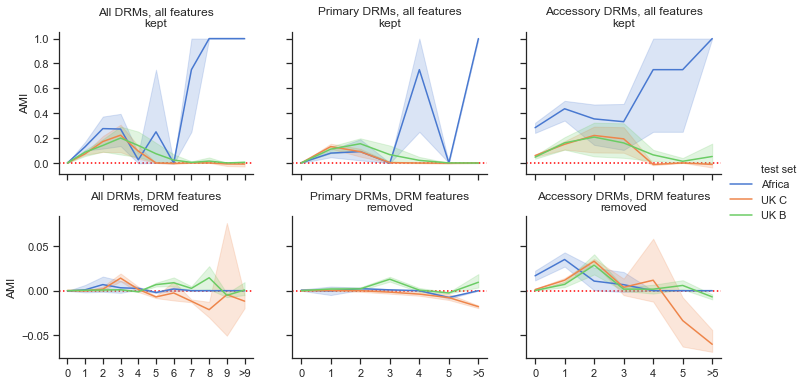

In [65]:
sns.set_context('notebook')
with sns.axes_style('ticks'):
    grid = (sns.FacetGrid(data=scores[scores['target']==targets[0]], col='count type', row='task', sharex='col', sharey="row", 
                          aspect=1.2, col_order=count_order[:1] + count_order[3:5], row_order=tasks, 
                          gridspec_kws={'wspace': 0.2, 'hspace':0.3})
                .map_dataframe(plot_line_facet, x='count', y='AMI', hue='test set', 
                               hue_order=test_sets, palette='muted',
                               pointargs={'size':5, 'style':'shorthand'})
                .map(plt.axhline, y=0, ls=':', color='red', zorder=0.2)
                .set_titles(template="{col_name}, {row_name}")
                .set_ylabels('AMI')
                .add_legend())
grid.savefig(os.path.join(dirname, targets[0], 'grouped_AMI.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

In [106]:
indexer = ['task', 'shorthand', 'target', 'test set']
all_count_freqs = (subset.groupby(indexer)
        .apply(lambda x: x.filter(regex=r'count',axis=1).apply(lambda y: y.value_counts(normalize=True)))
        .reset_index())

In [119]:
prevalences = pd.melt(all_count_freqs.rename({'level_4': 'count'}, axis=1), 
                      id_vars=indexer + ['count'])
prevalences['count type'] = prevalences['variable'].apply(lambda x: " ".join(x.split()[:-1]))
prevalences['count'] = prevalences['count'].apply(lambda x: x[1:] if x[0] == "="else f">{int(x[2:])-1}")
prevalences['shorthand'] = prevalences['shorthand'].apply(lambda x: {'B1':'FC'}.get(x,x))

In [135]:
grouper = indexer + ['count', 'count type']
scores = (scores.set_index(grouper)
                .join(prevalences.set_index(grouper)['value'])
                .rename({'value':'prevalence'}, axis=1)
                .reset_index())

In [139]:
for measure in ['Balanced accuracy', 'AMI']:
    scores[f"weighted {measure}"] = scores['prevalence'] * scores[measure]

In [140]:
scores

task shorthand         target test set count  \
0     DRM features\nremoved        FC  encoded_label   Africa     0   
1     DRM features\nremoved        FC  encoded_label   Africa     1   
2     DRM features\nremoved        FC  encoded_label   Africa     2   
3     DRM features\nremoved        FC  encoded_label   Africa     3   
4     DRM features\nremoved        FC  encoded_label   Africa     4   
...                     ...       ...            ...      ...   ...   
2683     all features\nkept        RF         hasDRM     UK C     4   
2684     all features\nkept        RF         hasDRM     UK C     5   
2685     all features\nkept        RF         hasDRM     UK C     6   
2686     all features\nkept        RF         hasDRM     UK C     7   
2687     all features\nkept        RF         hasDRM     UK C    >7   

          count type  nb. of sequences           AMI  Balanced accuracy  \
0     Accessory DRMs            2727.0  1.767983e-02           0.559777   
1     Accessory DRMs             681.0  4.480620e-02           0.607720   
2     Accessory DRMs             299.0  8.840705e-04           0.548071   
3     Accessory DRMs             140.0 -2.139185e-03           0.412935   
4     Accessory DRMs              81.0  2.372290e-15           0.518519   
...              ...               ...           ...                ...   
2683           SDRMs             170.0  1.000000e+00           1.000000   
2684           SDRMs              94.0  1.000000e+00           1.000000   
2685           SDRMs              57.0  1.000000e+00           1.000000   
2686           SDRMs              27.0  1.000000e+00           1.000000   
2687           SDRMs              26.0  1.000000e+00           1.000000   

      prevalence  weighted Balanced accuracy  weighted AMI  
0       0.683459                    0.382585  1.208343e-02  
1       0.170677                    0.103724  7.647375e-03  
2       0.074937                    0.041071  6.624989e-05  
3       0.035088                    0.014489 -7.505912e-05  
4       0.020301                    0.010526  4.815928e-17  
...          ...                         ...           ...  
2683    0.009587                    0.009587  9.586646e-03  
2684    0.005301                    0.005301  5.300852e-03  
2685    0.003214                    0.003214  3.214346e-03  
2686    0.001523                    0.001523  1.522585e-03  
2687    0.001466                    0.001466  1.466193e-03  

[2688 rows x 12 columns]

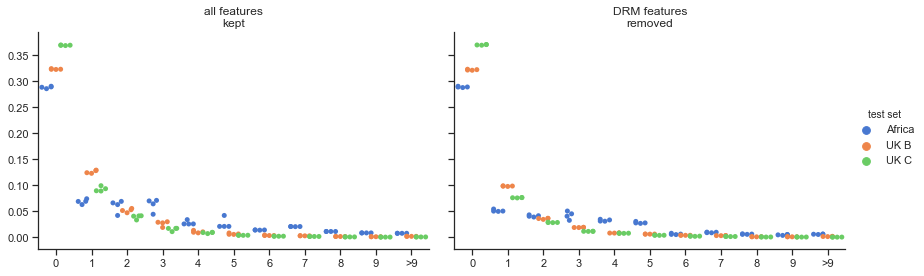

In [158]:
to_plot = scores[
    (scores['target'] == targets[0]) & 
    (scores['count type'] == 'All DRMs') 
]

with sns.axes_style('ticks'):
    grid = (sns.FacetGrid(data=to_plot, col='task', col_order=tasks, height=4, aspect=1.5)
            .map_dataframe(sns.swarmplot,x='count', y='weighted Balanced accuracy', hue='test set', dodge=True, palette='muted')
            .set_titles(template="{col_name}")
            .add_legend(title='test set'))
grid.savefig(os.path.join(dirname, targets[0], 'weighted_accuracy.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

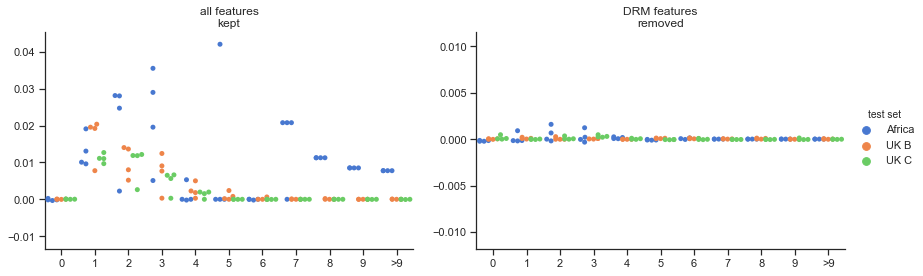

In [159]:
with sns.axes_style('ticks'):
    grid = (sns.FacetGrid(data=to_plot, col='task', col_order=tasks, height=4, aspect=1.5, sharey=False)
            .map_dataframe(sns.swarmplot,x='count', y='weighted AMI', hue='test set', dodge=True, palette='muted')
            .set_titles(template="{col_name}")
            .add_legend(title='test set'))
grid.savefig(os.path.join(dirname, targets[0], 'weighted_AMI.pdf'), format='pdf', alpha=.99, bbox_inches='tight')